<a href="https://colab.research.google.com/github/cdixson-ds/DS-Unit-2-Linear-Models/blob/master/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"

df = df.drop(columns=['Rec', 'overall'])

In [68]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


Train/validate/test split

In [69]:
#Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

from datetime import datetime
pd.options.mode.chained_assignment = None

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df['Date'].describe
df.shape

(421, 59)

In [0]:
train = df[df['Date'].dt.year <= 2016]
val = df[df['Date'].dt.year == 2017]
test = df[df['Date'].dt.year >= 2018]


Baseline

In [71]:
#Begin with baselines for classification.
#Roughly 40% of burritos are 'great'

target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [0]:
#What if we guessed the majority class for every prediction?

majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)


In [73]:
# Training accuracy of majority class baseline = 
# frequency of majority class (aka base rate)

from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_pred)

0.5906040268456376

In [74]:
#Validation accuracy of majority class baseline=
#usually similar to Train accuracy

y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

Linear Regression

In [103]:
#Start with linear regression for intuition, and fun

train.describe().T

,count,mean,std,min,25%,50%,75%,max
Yelp,71.0,3.897183,0.478680,2.50,3.5000,4.00,4.00,4.50
Google,71.0,4.142254,0.371738,2.90,4.0000,4.20,4.40,4.90
Cost,292.0,6.896781,1.211412,2.99,6.2500,6.85,7.50,11.95
Hunger,297.0,3.445286,0.852150,0.50,3.0000,3.50,4.00,5.00
Mass (g),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Density (g/mL),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length,175.0,19.829886,2.081275,15.00,18.5000,19.50,21.00,26.00
Circum,174.0,22.042241,1.685043,17.00,21.0000,22.00,23.00,27.00
Volume,174.0,0.770920,0.137833,0.40,0.6625,0.75,0.87,1.24
Tortilla,298.0,3.472315,0.797606,1.40,3.0000,3.50,4.00,5.00


In [107]:
#1 Import estimator class
from sklearn.linear_model import LinearRegression

#2 Instantiate this class
linear_reg = LinearRegression()

#3 Arrange X feature matrices(already did y target vectors)
features = ['Fillings', 'Tortilla', 'Temp']
#no more than 3 features?

X_train = train[features]
X_val = val[features]

#4 Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

#5 Fit the model
linear_reg.fit(X_train_imputed, y_train)

linear_reg.predict(X_val_imputed)

array([ 0.5105722 ,  0.47173739,  0.2729031 ,  0.2808737 ,  0.08042785,
        0.2340683 ,  0.69507686,  0.58340713,  0.0315047 ,  0.59298928,
        0.57979534,  0.2925736 ,  0.5222721 ,  0.2340683 ,  0.78546453,
        0.45579621,  0.41282483,  0.56746594,  0.49301945,  0.78546453,
        0.57543653,  0.20642721,  0.25162105,  0.50838226,  0.73865914,
        0.58340713,  0.70899922,  0.47334895,  0.45579621,  0.4630114 ,
        0.68135813,  0.2808737 ,  0.18251543,  0.32606753,  0.38296128,
        0.42018452,  0.38136831,  0.55576603,  0.50195698,  0.50280524,
        0.3042071 ,  0.35370863,  0.35532019,  0.69507686,  0.56373663,
        0.51854279, -0.08652407,  0.17878612,  0.57543653, -0.13332946,
        0.08839844,  0.46537836,  0.50838226,  0.50838226,  0.30851479,
        0.12401013,  0.08678689,  0.26332095,  0.32606753,  0.35370863,
       -0.3885513 ,  0.32659233,  0.2729031 ,  0.45148852,  0.65785361,
        0.62063037,  0.5105722 ,  0.98963969,  0.16123337,  0.52

In [111]:
#Get coefficients
pd.Series(linear_reg.coef_, features)

Fillings    0.294563
Tortilla    0.090388
Temp        0.074446
dtype: float64

In [112]:
test_case = [[4, 4, 4]] #hot burrito?
linear_reg.predict(test_case)  

array([0.62063037])

Logistic Regression

In [113]:
#Use scikit-learn for logistic regression
#Is the validation better than the baseline? yes

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

Validation Accuracy 0.788235294117647


In [114]:
#This is what predictions look like
#Do I need to convert these to numeric?

log_reg.predict(X_val_imputed)

array([ True, False, False, False, False, False,  True,  True, False,
        True,  True, False,  True, False,  True, False, False,  True,
       False,  True,  True, False, False, False,  True,  True,  True,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True,  True,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False, False, False,  True,  True,  True, False,
        True, False,  True,  True])

In [115]:
log_reg.predict(test_case)

array([ True])

In [116]:
log_reg.predict_proba(test_case)

array([[0.31136579, 0.68863421]])

In [117]:
log_reg.coef_

array([[1.99247739, 0.65866746, 0.5021586 ]])

In [0]:
#The logistic sigmoid 'squishing' function, implemented to accept numpy arrays
import numpy as np

def sigmoid(x):
  return 1/ (1 + np.e**(-x))

In [119]:
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

array([[0.68863421]])

Get validation accuracy

In [124]:
features = ['Synergy', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Wrap', 'Temp']
target = 'Great'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((298, 7), (298,), (85, 7), (85,))

Plot coefficients:

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [127]:
X_train_encoded.head()

,Synergy,Fillings,Meat:filling,Uniformity,Salsa,Wrap,Temp
0,4.0,3.5,4.0,4.0,4.0,4.0,5.0
1,2.5,2.5,2.0,4.0,3.5,5.0,3.5
2,3.0,3.0,4.5,4.0,3.0,5.0,2.0
3,4.0,3.0,4.0,5.0,4.0,5.0,2.0
4,4.5,3.5,4.5,5.0,2.5,4.0,5.0


In [130]:
X_val_encoded.head()

,Synergy,Fillings,Meat:filling,Uniformity,Salsa,Wrap,Temp
301,3.50,3.5,3.5,5.0,1.5,4.5,4.5
302,3.75,4.0,NaN,4.6,4.2,5.0,2.0
303,4.20,3.0,3.7,4.0,4.3,5.0,4.5
304,3.80,3.0,4.0,4.5,4.0,4.8,4.0
305,2.00,2.5,3.0,3.0,2.0,4.0,4.5


In [0]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [132]:
X_train_imputed[:5]

array([[4. , 3.5, 4. , 4. , 4. , 4. , 5. ],
       [2.5, 2.5, 2. , 4. , 3.5, 5. , 3.5],
       [3. , 3. , 4.5, 4. , 3. , 5. , 2. ],
       [4. , 3. , 4. , 5. , 4. , 5. , 2. ],
       [4.5, 3.5, 4.5, 5. , 2.5, 4. , 5. ]])

In [133]:
#this line of code turns it back into a pandas dataframe

pd.DataFrame(X_train_imputed, columns=X_train_encoded.columns)

,Synergy,Fillings,Meat:filling,Uniformity,Salsa,Wrap,Temp
0,4.0,3.5,4.0,4.0,4.00000,4.0,5.0
1,2.5,2.5,2.0,4.0,3.50000,5.0,3.5
2,3.0,3.0,4.5,4.0,3.00000,5.0,2.0
3,4.0,3.0,4.0,5.0,4.00000,5.0,2.0
4,4.5,3.5,4.5,5.0,2.50000,4.0,5.0
...,...,...,...,...,...,...,...
293,2.0,3.0,4.2,4.0,3.00000,4.5,1.5
294,2.5,2.0,2.5,3.5,3.00000,3.0,5.0
295,3.3,3.3,1.4,2.3,2.20000,4.5,2.5
296,2.0,2.0,3.5,3.5,2.00000,4.0,4.5


In [136]:
X_val_imputed[:5]

array([[3.5       , 3.5       , 3.5       , 5.        , 1.5       ,
        4.5       , 4.5       ],
       [3.75      , 4.        , 3.52886986, 4.6       , 4.2       ,
        5.        , 2.        ],
       [4.2       , 3.        , 3.7       , 4.        , 4.3       ,
        5.        , 4.5       ],
       [3.8       , 3.        , 4.        , 4.5       , 4.        ,
        4.8       , 4.        ],
       [2.        , 2.5       , 3.        , 3.        , 2.        ,
        4.        , 4.5       ]])

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [140]:
X_train_scaled

array([[ 0.50099338, -0.02244697,  0.4582244 , ...,  0.72124523,
         0.03868647,  1.34069563],
       [-1.13340089, -1.20240271, -1.48698931, ...,  0.18727406,
         0.89967866, -0.21386677],
       [-0.5886028 , -0.61242484,  0.94452783, ..., -0.34669711,
         0.89967866, -1.76842918],
       ...,
       [-0.26172395, -0.25843812, -2.07055342, ..., -1.20105098,
         0.46918257, -1.25024171],
       [-1.67819898, -1.79238058, -0.02807903, ..., -1.41463945,
         0.03868647,  0.82250816],
       [ 0.28307414, -0.61242484,  0.26370303, ...,  0.        ,
        -1.6832979 ,  0.3043207 ]])

In [141]:
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.8588235294117647


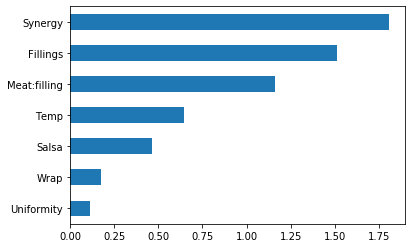

In [144]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

In [128]:
X_train_encoded.columns

Index(['Synergy', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Wrap',
       'Temp'],
      dtype='object')